# SingStrain_ML_Regression 
    
    In the following notebook we use single strain calibration data to build
    multiple lineaer regression models. Visualizations are done in the Vis_SingStrain
    Notebook

# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import scipy

from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='whitegrid')

import itertools as it

%config InteractiveShell.ast_node_interactivity='all'
%config InlineBackend.figure_format = 'svg'

# Helper Functions

In [2]:
def set_B_and_C(tdf, column):
    """This helper function sets the concentraiton values B and
    C on the dataframe for regressiong purposes and so that the 
    plotting function can plot the right values on the x-axis"""
    
    df = tdf.copy()
    
    rows = df['row'].unique()
    cols =  df['col'].unique()
    
    for row in rows:
        value = df.loc[(df['row']==row) & (df['col']==12), column][0]
        df.loc[df['row']==row, 'B'] = value

    for col in cols:
        value = df.loc[(df['row']=='H') & (df['col']==col), column][0]
        df.loc[df['col']==col, 'C'] = value
    
    return df

In [3]:
def MLR_fitter(dframe, regressor_waves= ['A680', '720'], regressand='560', metrics=False):
    """This function returns the fitters from a multiple linear regression that
    regress back to [B] and [C], i.e. the returned fitters allow you to make predictions
    """
    
    df=dframe.copy()
    
    X = df[regressor_waves]
    
    yB = set_B_and_C(df,regressand)[['B']]
    yC = set_B_and_C(df,regressand)[['C']]

    XtrnB, XtstB, ytrnB, ytstB = train_test_split(X, yB, test_size=0.20, random_state=7)
    XtrnC, XtstC, ytrnC, ytstC = train_test_split(X, yC, test_size=0.20, random_state=7)

    rB = LinearRegression().fit(XtrnB, ytrnB)
    rC = LinearRegression().fit(XtrnC, ytrnC)
    
    if metrics==True:
        """If metrics true it returns the test variables to check the fits"""
        return rB, rC, XtstB, ytstB, XtstC, ytstC
    
    return rB, rC


def get_MLR_predictions(dframe, regressor_waves=['A680', '720'], regressand='560', regressors_B_C=None):
    """Returns the complete predictions for the regresor as series 
    which can be appended to an existing dataframe. If regressors are passed it ingores
    the regressor waves and regressand and only returns the predicitons using
    those regressors"""
    
    if regressors_B_C==None:
        """If regressors haven't been created previously with MLR_fitter(), then this
        function first calls that function to assess the predictions over the regressand series"""
        
        regressors_B_C = MLR_fitter(dframe, regressor_waves, regressand)
        
    df = dframe.copy()
    
    df['B_pML_'+regressand] = regressors_B_C[0].predict(df[regressor_waves])
    df['C_pML_'+regressand] = regressors_B_C[1].predict(df[regressor_waves])
    
    return df[['B_pML_'+regressand ,'C_pML_'+regressand]]
    

def get_model_metrics(dframe, regressor_waves=['A680', '720'],regressand='560',regressors_B_C=None):
    
    df = dframe.copy()
    
    if regressors_B_C==None:
        """This prints out goodness-of-fit for any regressor and regressand for the
        MODELS and TEST DATA only and returns the models as well so that you
        can use them to make the predictions.
        """
        rB, rC, XtstB, ytstB, XtstC, ytstC = MLR_fitter(df, regressor_waves,
                                                  regressand, metrics=True)
        
        
        ypB = rB.predict(XtstB)
        ypC = rC.predict(XtstC)
        
        print('Bp_'+regressand+'_MSE', mse(ytstB, ypB))
        print('Bp_'+regressand+'_R^2', r2s(ytstB, ypB))
        
        print('Cp_'+regressand+'_MSE', mse(ytstC, ypC))
        print('Cp_'+regressand+'_R^2', r2s(ytstC, ypC))
        
        return rB, rC
    
    elif regressors_B_C:
        
        """This prints out the good-of-fit values for all of the predictions against
        the actual regressand values, to double-check these values run the rB rC predictors
        on the entirity of the [regressors] wavelength"""
        
        df = set_B_and_C(dframe, regressand)
        
        ypB = regressors_B_C[0].predict(df[regressor_waves])
        ypC = regressors_B_C[1].predict(df[regressor_waves])       
        
        print('Bp_'+regressand+'_MSE', mse(df[['B']], ypB))
        print('Bp_'+regressand+'_R^2',r2s(df[['B']], ypB))
        
        print('Cp_'+regressand+'_MSE',mse(df[['C']], ypC))
        print('Cp_'+regressand+'_R^2',r2s(df[['C']], ypC))


def get_model_coefficients(dframe, regressand):
    
    rB, rC = MLR_fitter(dframe, regressand=regressand)
    
    return rB.coef_[0][0], rB.coef_[0][1], rC.coef_[0][0], rC.coef_[0][1]

# Data

In [4]:
folder='/home/rdmtinez/Documents/B-IT MS Program/Masters Thesis/data/abs-flu/exp1/tecan_results/'
fname='predicted_values_of_different_regression.csv'

In [5]:
df = pd.read_csv('./predicted_values_of_different_regression.csv', index_col=0)

# Pre-Processing

In [6]:
# the data above has the predictions of the simple linear regression, for this
# ML regression we only need the values of the measurements

In [7]:
mdf=df[df.columns.values[:104]]

In [8]:
mdf.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,755,760,765,770,775,780,785,790,795,800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.4148,0.4122,0.4095,0.4067,0.4043,0.4019,0.3995,0.3977,0.3955,0.3937
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.4158,0.4129,0.4099,0.4070,0.4041,0.4014,0.3989,0.3967,0.3943,0.3923
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.3793,0.3768,0.3741,0.3710,0.3688,0.3665,0.3642,0.3622,0.3600,0.3582
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.3473,0.3447,0.3418,0.3389,0.3366,0.3342,0.3319,0.3299,0.3277,0.3258
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.3319,0.3293,0.3266,0.3236,0.3214,0.3191,0.3168,0.3146,0.3124,0.3105


# ML Parameter Learning

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score as r2s
import statsmodels.api as sm

# Check Coherence of Functions
    
### Predictor Metrics on all  X,y ([A680, 720] ~ [560])

In [10]:
# return fitted models, note regressor waves should always be A680, 720
# as these are the wavelengths at which the PBR monitors growth
rB, rC = MLR_fitter(mdf, regressor_waves= ['A680', '720'], regressand='560')

In [13]:
# the coefficients are
# by column ins


'kB680m', 'kB720m', 'kC680m', 'kC720m'
rB.coef_[0], rC.coef_[0]


('kB680m', 'kB720m', 'kC680m', 'kC720m')

(array([-0.97465427,  2.13758878]), array([ 0.9206069 , -0.83122028]))

In [46]:
# Predictions for ALL 96 wells
yPs = get_MLR_predictions(mdf, regressors_B_C=[rB, rC])
ypB = yPs.iloc[:,0]
ypC = yPs.iloc[:,1]

In [47]:
# check the above predictions against the known values 
#(i.e. the actual a560 values) using mse and r2s
B=set_B_and_C(mdf, '560')[['B']]
C=set_B_and_C(mdf, '560')[['C']]


regressand='560'
print('Bp_'+regressand+'_MSE', mse(B, ypB))
print('Bp_'+regressand+'_R^2',r2s(B, ypB))

print('Cp_'+regressand+'_MSE',mse(C, ypC))
print('Cp_'+regressand+'_R^2',r2s(C, ypC))

Bp_560_MSE 0.0003035962327544889
Bp_560_R^2 0.9635929312647024
Cp_560_MSE 0.001142335543763987
Cp_560_R^2 0.9088673481962528


In [48]:
# those results should match these, ensure that regressors were fitted
# to proper regressand wavelength
get_model_metrics(mdf,  regressand='560', regressors_B_C=(rB,rC))


Bp_560_MSE 0.0003035962327544889
Bp_560_R^2 0.9635929312647024
Cp_560_MSE 0.001142335543763987
Cp_560_R^2 0.9088673481962528


### Coherence on Model Metrics (Xtst, ytst) 

In [49]:
rB, rC, XtstB, ytstB, XtstC, ytstC = MLR_fitter(mdf, regressand='560', metrics=True)

# check the fit against the test split
ypB = rB.predict(XtstB)
ypC = rC.predict(XtstC)

# these following values should match
regressand='560'
print('Bp_'+regressand+'_MSE', mse(ytstB, ypB))
print('Bp_'+regressand+'_R^2', r2s(ytstB, ypB))

print('Cp_'+regressand+'_MSE', mse(ytstC, ypC))
print('Cp_'+regressand+'_R^2', r2s(ytstC, ypC))

Bp_560_MSE 0.00013546384698475585
Bp_560_R^2 0.9793482610027094
Cp_560_MSE 0.0005373192615197944
Cp_560_R^2 0.9565186305873169


In [50]:
# these values
get_model_metrics(mdf, regressor_waves=['A680', '720'], regressand='560',regressors_B_C=None)


Bp_560_MSE 0.00013546384698475585
Bp_560_R^2 0.9793482610027094
Cp_560_MSE 0.0005373192615197944
Cp_560_R^2 0.9565186305873169


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [51]:
# Models on A750

In [52]:
get_model_metrics(mdf, regressor_waves=['A680', '750'], regressand='560',regressors_B_C=None)
print('---')
get_model_metrics(mdf, regressor_waves=['A680', 'A750'], regressand='560',regressors_B_C=None)

Bp_560_MSE 0.00011099725595040606
Bp_560_R^2 0.9830782425693166
Cp_560_MSE 0.000522155227763888
Cp_560_R^2 0.9577457463837281


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

---
Bp_560_MSE 0.0001009908568321655
Bp_560_R^2 0.9846037384672435
Cp_560_MSE 0.0004382586598443789
Cp_560_R^2 0.9645348900519568


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

In [53]:
# Note that the original model is a bit better

# Track ALL Possible Model Metrics

In [54]:
lambdas = mdf.columns.values[6:]
lambdas

array(['A750', '320', '325', '330', '335', '340', '345', '350', '355',
       '360', '365', '370', '375', '380', '385', '390', '395', '400',
       '405', '410', '415', '420', '425', '430', '435', '440', '445',
       '450', '455', '460', '465', '470', '475', '480', '485', '490',
       '495', '500', '505', '510', '515', '520', '525', '530', '535',
       '540', '545', '550', '555', '560', '565', '570', '575', '580',
       '585', '590', '595', '600', '605', '610', '615', '620', '625',
       '630', '635', '640', '645', '650', '655', '660', '665', '670',
       '675', '680', '685', '690', '695', '700', '705', '710', '715',
       '720', '725', '730', '735', '740', '745', '750', '755', '760',
       '765', '770', '775', '780', '785', '790', '795', '800'],
      dtype=object)

In [55]:
# It would be better to visualize these prediction values by
# putting them on a dataframe
for wave in lambdas:
    print('\n', wave)
    get_model_metrics(mdf, regressand=wave)
    break


 A750
Bp_A750_MSE 0.00010111320525164715
Bp_A750_R^2 0.9786026493163207
Cp_A750_MSE 0.00047372222032090365
Cp_A750_R^2 0.9455863675729971


(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False))

# Perform MLR Predictions for ALL Regressands

In [56]:
lambdas = mdf.columns.values[6:]
#get_MLR_predictions(dframe, regressor_waves=['A680', '720'], regressand='560', regressors_B_C=None):
tdf = mdf.copy()
for wave in lambdas:
    df = pd.merge(df, get_MLR_predictions(tdf, regressand=wave), left_index=True, right_index=True, )
    

In [58]:
df.to_csv('corrected_wavelen_and_predictions.csv')

In [59]:
df.head()

,row,col,B_lbl,C_lbl,F680,A680,A750,320,325,330,...,B_pML_780,C_pML_780,B_pML_785,C_pML_785,B_pML_790,C_pML_790,B_pML_795,C_pML_795,B_pML_800,C_pML_800
well,,,,,,,,,,,,,,,,,,,,,
A1,A,1,0.200,0.25,4666.0,0.7210,0.4146,0.8399,0.8359,0.8349,...,0.211322,0.205691,0.210304,0.204017,0.209473,0.202604,0.208496,0.201029,0.207587,0.199716
B1,B,1,0.175,0.25,4832.0,0.7822,0.4155,0.8916,0.8890,0.8907,...,0.171481,0.242862,0.170650,0.240894,0.169978,0.239228,0.169178,0.237381,0.168445,0.235829
C1,C,1,0.150,0.25,4638.0,0.6925,0.3829,0.7923,0.7897,0.7912,...,0.173228,0.207293,0.172388,0.205607,0.171706,0.204181,0.170897,0.202592,0.170155,0.201266
D1,D,1,0.125,0.25,4775.0,0.6981,0.3593,0.7690,0.7657,0.7669,...,0.113628,0.229376,0.113065,0.227514,0.112620,0.225936,0.112074,0.224182,0.111594,0.222714
E1,E,1,0.100,0.25,4936.0,0.6788,0.3414,0.7440,0.7413,0.7438,...,0.102288,0.225634,0.101778,0.223802,0.101378,0.222249,0.100881,0.220521,0.100451,0.219076


# Save All Model Coefficients


In [60]:
cdf = pd.read_csv('all_model_coefficients.csv', index_col=0, )
cdf.head()

,kB680,kC680,kB720,kC720
320,0.649097,1.061378,0.612967,0.477417
325,0.655980,1.065207,0.619460,0.479171
330,0.664168,1.060534,0.627196,0.477109
335,0.672943,1.052160,0.635481,0.473364
340,0.681380,1.052421,0.643450,0.473503


In [61]:
loc=4
for col in ['kB680m', 'kB720m', 'kC680m', 'kC720m']:
    cdf.insert(loc, col, value=None)
    loc+=1


In [63]:
cdf.head()

,kB680,kC680,kB720,kC720,kB680m,kB720m,kC680m,kC720m
320,0.649097,1.061378,0.612967,0.477417,None,None,None,None
325,0.655980,1.065207,0.619460,0.479171,None,None,None,None
330,0.664168,1.060534,0.627196,0.477109,None,None,None,None
335,0.672943,1.052160,0.635481,0.473364,None,None,None,None
340,0.681380,1.052421,0.643450,0.473503,None,None,None,None


In [ ]:
for reg in cdf.index.values:
        
    cdf.loc[reg,['kB680m', 'kB720m', 'kC680m', 'kC720m']] = [i for i in get_model_coefficients(mdf, regressand=str(reg))]

In [65]:
cdf.head()

,kB680,kC680,kB720,kC720,kB680m,kB720m,kC680m,kC720m
320,0.649097,1.061378,0.612967,0.477417,-1.38409,3.03725,1.61864,-1.46352
325,0.655980,1.065207,0.619460,0.479171,-1.36957,3.00521,1.61233,-1.45723
330,0.664168,1.060534,0.627196,0.477109,-1.35282,2.96839,1.61811,-1.46139
335,0.672943,1.052160,0.635481,0.473364,-1.33526,2.92974,1.62969,-1.47063
340,0.681380,1.052421,0.643450,0.473503,-1.31881,2.89361,1.62838,-1.46855


In [66]:
cdf.to_csv('all_model_coefficients_slr_mlr.csv')

NameError: name 'ytst' is not defined

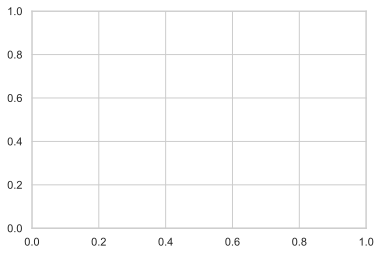

In [67]:
fig, ax = plt.subplots()
ax.scatter(ytst, ypC)
ax.plot([ytst.min(), ytst.max()], [ytst.min(), ytst.max()], 'k--', lw=2)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()

In [68]:
mean_squared_error(ytst, ypC)
r2s(ytst, ypC)

NameError: name 'mean_squared_error' is not defined

In [69]:
Xtrn, Xtst, ytrn, ytst = train_test_split(X, yB, test_size=0.5, random_state=777)
regressB = LinearRegression().fit(Xtrn,ytrn)
regressB.coef_

NameError: name 'X' is not defined

In [70]:
ypB = regressB.predict(Xtst)
ypB

NameError: name 'regressB' is not defined

In [71]:
mean_squared_error(ytst, ypB)
r2s(ytst, ypB)

NameError: name 'mean_squared_error' is not defined

NameError: name 'ytst' is not defined

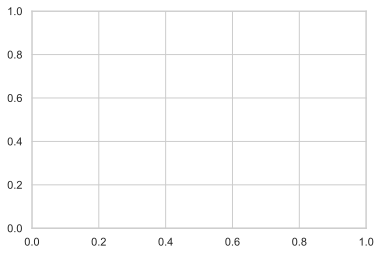

In [72]:
fig, ax = plt.subplots()
ax.scatter(ytst, ypB)
ax.plot([ytst.min(), ytst.max()], [ytst.min(), ytst.max()], 'k--', lw=2)
ax.set_xlabel('measured')
ax.set_ylabel('predicted')
plt.show()